[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sevgiozturk/Duke_ComputationalNeuroscienceandModeling/blob/main/w6/Week6_2_NeuralDecoding_PopulationVector.ipynb)

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)

local=0
dir=''

if not local:
    print('Load from remote!')
    url = ["https://osf.io/agvxh/download"]
    url.append("https://osf.io/uv3mw/download")
    url.append("https://osf.io/ehmw2/download")

    for j in range(len(url)):
      if not os.path.isfile(fname[j]):
        try:
          r = requests.get(url[j])
        except requests.ConnectionError:
          print("!!! Failed to download data !!!")
        else:
          if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
          else:
            with open(fname[j], "wb") as fid:
              fid.write(r.content)
else:
    dir='D:\exampleCodes\SteinmetzData\\' #local dir not to try loading everytime
    print('Load from local:'+dir)

Load from remote!


In [ ]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load(dir+'steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


In [ ]:
from matplotlib import pyplot as plt
from scipy import stats

# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]
ba_we_choose=  ['MOp']
#ba_we_choose=['SSp', 'SSs', 'MOp', 'MOs'] # Sevgi
meanSpikeRatePerRegionPerNeuron={}
responsePerRegionPerNeuron={}
stim_rightPerRegion={}
stim_leftPerRegion={}

for j in range(len(ba_we_choose)):
  # select just one of the recordings here. 5,6,15,20,28 has SSp recordings
  for i in range(len(alldat)):
    dat = alldat[i]   # iterate each recording session
    spks=dat['spks']
    ba=dat['brain_area']
    dt = dat['bin_size'] # binning at 10 ms (sampling rate=100K ?)
    response = dat['response'] # right - nogo - left (-1, 0, 1)
    stim_right = dat['contrast_right'] # 0 - low - high
    stim_left = dat['contrast_left'] # 0 - low - high

    if len(ba[ba==ba_we_choose[j]]): # if this recording session has data from that specific brain region
      ssp=dat['spks'][ba==ba_we_choose[j]] # session 5 has 11 neurons from that specific brain region(ie;SSp)
      numberOfNeurons = ssp.shape[0]
      print('Found {0} at {1}th recording for {2} neurons'.format(ba_we_choose[j], i, numberOfNeurons)) # which recording sessions to choose

      if ba_we_choose[j] in meanSpikeRatePerRegionPerNeuron:
        meanSpikeRatePerNeuron = meanSpikeRatePerRegionPerNeuron[ba_we_choose[j]]
        responsePerNeuron = responsePerRegionPerNeuron[ba_we_choose[j]]

        oldLen = len(meanSpikeRatePerNeuron)
        for ii in range(numberOfNeurons): # for each new neuron, just add spike rates of trials as a new row
          meanSpikeRatePerNeuron[oldLen+ii]=(ssp[ii]/dt).mean(axis=(1)) # spike rates of all trials
          responsePerNeuron[oldLen+ii] = response
      else:
        meanSpikeRatePerNeuron = {} # neurons x trials
        responsePerNeuron = {}
        for ii in range(numberOfNeurons): # for each neuron
          meanSpikeRatePerNeuron[ii] = (ssp[ii]/dt).mean(axis=(1)) # this is actually meanSpikeRate per neuron per trial
          responsePerNeuron[ii] = response

      meanSpikeRatePerRegionPerNeuron[ba_we_choose[j]] = meanSpikeRatePerNeuron
      responsePerRegionPerNeuron[ba_we_choose[j]] = responsePerNeuron

      print(['len=', len(meanSpikeRatePerNeuron)])
  # qq=meanSpikeRatePerRegionPerNeuron['SSp']
  # print(qq)

Found MOp at 10th recording for 447 neurons
['len=', 447]
Found MOp at 20th recording for 166 neurons
['len=', 613]
Found MOp at 28th recording for 180 neurons
['len=', 793]


In [ ]:
spks[ba==ba_we_choose[j]].shape

(0, 343, 250)

Region=MOp neurons Neurons:793


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',






2013.0755568310356
Experimental Data has Right Responses:32.99% Left Responses:34.35% No Go Responses:32.66%


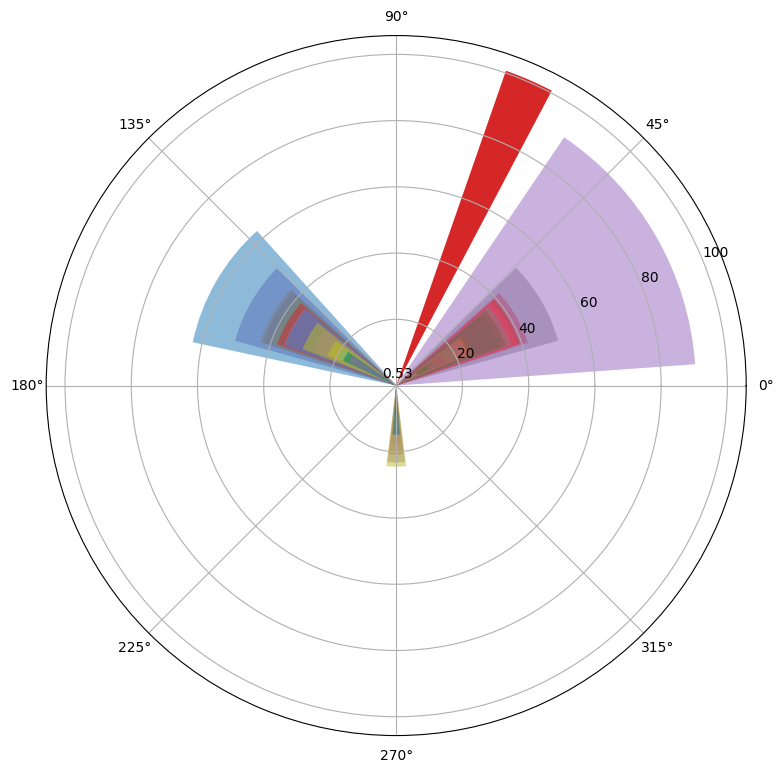

In [ ]:
from scipy.optimize import curve_fit
import random
import math

#   Cosine Tuning Function
#   Parameters
#   theta: direction of movement
#   b0, b1,b2: regression coefficients
#   Returns predicted firing rate for all directions in theta
def cosFunc(theta, b0, b1, b2):
  return b0 + b1*np.sin(theta) + b2*np.cos(theta) # as in paper Georgopoulos 1982 # could be p1 + p2*np.cos(theta-x)

def autolabel(rects, label=''):
    """Attach a text label above each bar in *rects*, displaying its height."""
    if not label:
      print(label)
      for rect in rects:
          height = np.round(rect.get_height(),2)
          ax.annotate(label,
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')
    else:
      for rect in rects:
          height = np.round(rect.get_height(),2)
          ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

initConditions=(1, 1, 1)
rightResponse = -1
noResponse = 0
leftResponse = 1

directions = np.array([np.pi/6, 5*np.pi/6, 3*np.pi/2]) # pi/6 = Right Response 5pi/6 = Left Response 3pi/2 = No Go Response

popVectorX = 0
popVectorY = 0
thr=50

fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(2, 1, 1, projection='polar')

globalRR=0
globalNR=0
globalLR=0

for brain_region,meanSpikeRatePerNeuron in meanSpikeRatePerRegionPerNeuron.items():

  responsePerNeuron = responsePerRegionPerNeuron[brain_region]
  print('Region={0} neurons Neurons:{1}'.format(brain_region,len(meanSpikeRatePerNeuron)))

  for neuronInd,spRatePerTrial in meanSpikeRatePerNeuron.items():
      responses = responsePerNeuron[neuronInd]

      countRR = sum(responses==rightResponse)
      countNR = sum(responses==noResponse)
      countLR = sum(responses==leftResponse)

      globalRR += countRR
      globalNR += countNR
      globalLR += countLR

      rightResponseFR = spRatePerTrial[responses==rightResponse].mean()
      noResponseFR = spRatePerTrial[responses==noResponse].mean()
      leftResponseFR = spRatePerTrial[responses==leftResponse].mean()
      FRs = np.array([rightResponseFR, leftResponseFR, noResponseFR]) # Max firing rate will be preferred direction

      #print('neuronInd={0} Trials:{1} Responses:{2}'.format(neuronInd,len(spRatePerTrial), responses))
      popt, pcov = curve_fit(cosFunc, directions, FRs, p0=initConditions) # [rightResponseFR, leftResponseFR, noResponseFR]
      b0 = popt[0]
      b1 = popt[1]
      b2 = popt[2]
      FS_hat = cosFunc(directions, b0, b1, b2)
      indMax=np.argmax(FS_hat)
      preferredDir = directions[indMax]  # get the highest activity direction
      x = FRs[indMax]*np.cos(preferredDir)
      y = FRs[indMax]*np.sin(preferredDir)
      #plt.polar(preferredDir, FRs[indMax], 'b') #polar(preferredDir, FRs[indMax], 'ro')
      bars = ax.bar(preferredDir, FRs[indMax], width=FRs[indMax]*.01, bottom=0.0, alpha=0.5)
      if FRs[indMax]>thr:
        autolabel(bars)

      #print(FRs[indMax])

      popVectorX = popVectorX + x
      popVectorY = popVectorY + y

      residuals = FRs-FS_hat
      fres = sum(residuals**2)
      #print('Least Squares=%.2f'%fres)

  popVector = np.sqrt(popVectorX*popVectorX + popVectorY*popVectorY);
  theta = math.atan(popVectorY/popVectorX)
  barPV = plt.bar(theta,popVector/20, width=0.15) #(theta, popVector/10) # width=popVector*.001, bottom=0.7,  alpha=0.3
  autolabel(bars,'Population Vector')
  print(popVector)

  sumAll=globalRR+globalLR+globalNR
  globalRR=np.round(globalRR/sumAll*100,2)
  globalLR=np.round(globalLR/sumAll*100,2)
  globalNR=np.round(globalNR/sumAll*100,2)
  print('Experimental Data has Right Responses:{0}% Left Responses:{1}% No Go Responses:{2}%'.format(globalRR,globalLR,globalNR))